In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm

import random

In [56]:
def compute_roc_and_areas(p_hat_list, significance_level=0.05):
    roc = []
    alphas = []

    for alpha in np.linspace(0, 1, 100):
        alphas.append(alpha)
        num_below_alpha = sum(p_hat_list < alpha)
        roc_point = num_below_alpha / len(p_hat_list)
        roc.append(roc_point)

    # Get the power at the significance level
    power_idx = alphas.index(min(alphas, key=lambda x: abs(x - significance_level)))
    power = roc[power_idx]

    # Calculate the area between ROC and y=x line
    def compute_area_above_below_curve(x, y):
        area_above = 0.0
        area_below = 0.0

        for i in range(1, len(x)):
            x0, x1 = x[i - 1], x[i]
            y0, y1 = y[i - 1], y[i]
            line0, line1 = x0, x1  # Since line y = x

            if y1 == y0:  # Vertical segment
                if y0 > x0:
                    area_above += (y0 - x0) * (x1 - x0)
                else:
                    area_below += (x0 - y0) * (x1 - x0)
                continue

            # Find intersection with y = x
            if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
                if y0 >= x0 and y1 >= x1:
                    area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
                else:
                    area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
            else:
                x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
                if y0 < x0:
                    area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                    area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
                else:
                    area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                    area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)

        return area_above, area_below

    x = np.linspace(0, 1, 100)
    roc_interpolated = np.interp(x, alphas, roc)

    # Compute areas
    area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
    total_area = area_above + area_below

    return {
        "area_above": area_above,
        "area_below": area_below,
        "total_area": total_area
    }

In [57]:
# Code up a mixed membership model 
random.seed(222)
np.random.seed(222)

K=3
n= 300
d=3

# use our new function to make a MMSBM 
# 1May24 I added return B to the function, so I can add to the paper what B is for our example
A, largest_prob, P, B = make_MMSBM(n, K)

A = A.astype(float)
ya = UASE([A], d)
# plot_embedding(ya, n, 1, largest_prob)

print(B) # seed keeps this B same everytime

[[0.3 0.2 0.2]
 [0.2 0.6 0.2]
 [0.2 0.2 0.9]]


### Use the test with samples drawn from the same distribution - compared to one bootstrap from itself each time

In [58]:
random.seed(222)
np.random.seed(222)

# make all the pi vectors (n of them)
pi_list = []
largest_prob = []
for i in range(n):
    # pi is a random probability vector of length K
    pi = np.random.dirichlet(np.ones(K)).reshape((K, 1))
    pi_list.append(pi)
    largest_prob.append(np.argmax(pi))

In [59]:
# Generate more samples from the same model with the same B matrix and pi vectors
random.seed(100)

M=300
A_true_draws = []

for m in range(M):
    # use the B matrix from before, B, and the pi vectors, pi_list
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            z_ij = np.random.multinomial(1, pi_list[i].flatten())#.tolist())
            z_ji = np.random.multinomial(1, pi_list[j].flatten())#.tolist())

            P[i,j] = z_ij @ B @ z_ji.T

    A = (np.random.uniform(0, 1, n**2).reshape(n, n) < P)

    A = A.astype(float)

    # make symmetric by setting the lower triangle equal to the upper triangle
    A = np.triu(A) + np.triu(A).T - np.diag(A.diagonal())

    A_true_draws.append(A)

    #3 mins runtime for M=300

In [60]:
Q = 1000

#### knn k=5

In [61]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

k=5

p_vals_k5 = []
A_boots_list_k5 = []

for m in A_true_draws:
    p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=k)
    p_vals_k5.append(p_val)
    A_boots_list_k5.append(A_boots)

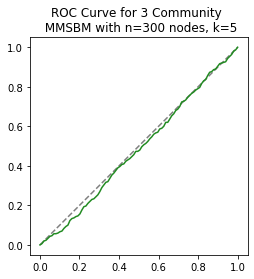

{'area_above': 0.000493178649055595,
 'area_below': 0.016106608117703956,
 'total_area': 0.01659978676675955}

In [62]:
p_hat_list = p_vals_k5
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for 3 Community \n MMSBM with n={n} nodes, k={k}")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig(f"MMSBM_knnBootstrap_k{k}_M{M}_SYMM.png", facecolor="white")

plt.show()


compute_roc_and_areas(p_vals_k5, significance_level=0.05)

#### knn k=25

In [63]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

k=25

p_vals_k25 = []
A_boots_list_k25 = []

for m in A_true_draws:
    p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=k)
    p_vals_k25.append(p_val)
    A_boots_list_k25.append(A_boots)

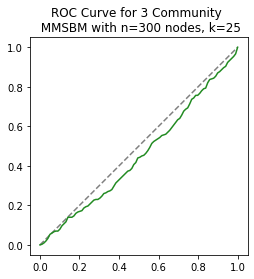

{'area_above': 3.1742792685553656e-06,
 'area_below': 0.04517258082302467,
 'total_area': 0.04517575510229323}

In [64]:
p_hat_list = p_vals_k25
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for 3 Community \n MMSBM with n={n} nodes, k={k}")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig(f"MMSBM_knnBootstrap_k{k}_M{M}_SYMM.png", facecolor="white")

plt.show()


compute_roc_and_areas(p_vals_k25, significance_level=0.05)

#### knn k=90

In [65]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

k=90

p_vals_k90 = []
A_boots_list_k90 = []

for m in A_true_draws:
    p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=k)
    p_vals_k90.append(p_val)
    A_boots_list_k90.append(A_boots)

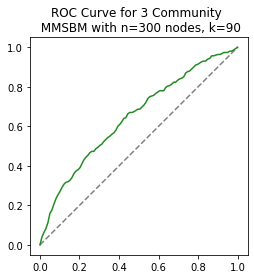

{'area_above': 0.14751453933272116,
 'area_below': 0.0,
 'total_area': 0.14751453933272116}

In [66]:
p_hat_list = p_vals_k90
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for 3 Community \n MMSBM with n={n} nodes, k={k}")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig(f"MMSBM_knnBootstrap_k{k}_M{M}_SYMM.png", facecolor="white")

plt.show()


compute_roc_and_areas(p_vals_k90, significance_level=0.05)

#### YYT

In [67]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals_YYT = []
A_boots_list_YYT = []

for m in A_true_draws:
    p_val, A_boots = create_single_YYT_bootstrap_cropPto0_1range(m,d=d,Q=1000)
    p_vals_YYT.append(p_val)
    A_boots_list_YYT.append(A_boots)

/home/uj21900/Documents/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:193: UserWarning: P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.
  warnings.warn("P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.")


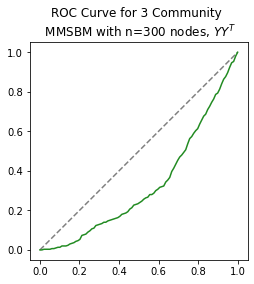

{'area_above': 0.0,
 'area_below': 0.17198143046627903,
 'total_area': 0.17198143046627903}

In [68]:
p_hat_list = p_vals_YYT
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for 3 Community \n MMSBM with n={n} nodes, $YY^T$")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig(f"figs/MMSBM_YYTbootstrap_M{M}_SYMM.png")
plt.show()

compute_roc_and_areas(p_vals_YYT, significance_level=0.05)

#### XXT

In [69]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals_XXT = []
A_boots_list_XXT = []

for m in A_true_draws:
    p_val, A_boots = create_single_XXT_bootstrap_cropPto0_1range(m,d=d,Q=1000)
    p_vals_XXT.append(p_val)
    A_boots_list_XXT.append(A_boots)

/home/uj21900/Documents/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:152: UserWarning: P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.
  warnings.warn("P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.")


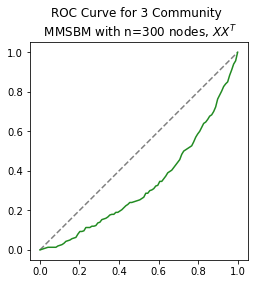

{'area_above': 0.0,
 'area_below': 0.1686970717273748,
 'total_area': 0.1686970717273748}

In [70]:
p_hat_list = p_vals_XXT
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for 3 Community \n MMSBM with n={n} nodes, $XX^T$")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig(f"figs/MMSBM_XXTbootstrap_M{M}_SYMM.png")
plt.show()

compute_roc_and_areas(p_vals_XXT, significance_level=0.05)

#### Sample edgelist with replacement bootstrap for each draw from the model

This is essentially just dropping some edges, as any edge selected more than once is set to a 1 as this is a binary setting

In [71]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals_ESWR = []
A_boots_list = []

Q=1000 # number of sims to do in the paired exch test

for m in A_true_draws:
    A_boots = edgelist_sample_with_replacement(m) 
    # embed the observed and bootstrapped matrix together
    yhat_est = UASE([m, A_boots], d=d)
    # do a test between the obs and the bootstrap, get a p-value ---------------------------------
    p_val = test_temporal_displacement_two_times(yhat_est, n=m.shape[0], n_sim=Q) 

    p_vals_ESWR.append(p_val)
    A_boots_list.append(A_boots[0])

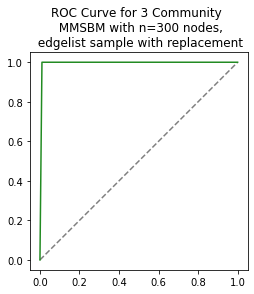

{'area_above': 0.4999489847974696,
 'area_below': 0.0,
 'total_area': 0.4999489847974696}

In [72]:
p_hat_list = p_vals_ESWR
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for 3 Community \n MMSBM with n={n} nodes,\n edgelist sample with replacement")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig(f"figs/MMSBM_edgelistSampleRepBootstrap_M{M}_SYMM.png")

plt.show()

compute_roc_and_areas(p_vals_ESWR, significance_level=0.05)

knn prone

In [73]:
def create_single_kNN_prone_bootstrap(A, d, Q=1000, n_neighbors=5):
    n = A.shape[0]
    A_obs = A.copy()
    # Embed the graphs -------------------------------
    yhat = unfolded_prone(A, d=d, flat=True)
    # run a k-NN on the embedding yhat
    # Here we use Minkowski distance, with p=2 (these are the defaults),
    # which corresponds to Euclidean distance
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(
        n_neighbors=n_neighbors, algorithm="ball_tree", metric="minkowski", p=2
    ).fit(yhat)
    distances, indices = nbrs.kneighbors(yhat)
    # Estimate the P matrix -------------------------------
    P_est = P_est_from_A_obs(n, A_obs, n_neighbors=n_neighbors, indices=indices)
    # Bootstrap -----------------------------------------
    A_est = make_inhomogeneous_rg(P_est)
    # embed the observed and bootstrapped matrices together --------------------------------
    yhat_est = UASE([A_obs, A_est], d=d)
    # do a test between the obs and the bootstrap, get a p-value ---------------------------------
    p_val = test_temporal_displacement_two_times(yhat_est, n, n_sim=Q)
    return p_val, A_est

In [74]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals_prone = []
A_boots_list = []

k=5
Q=1000 # number of sims to do in the paired exch test

for m in A_true_draws:
    _, A_boots = create_single_kNN_prone_bootstrap(m, d=d, Q=Q, n_neighbors=k) 

    # embed the observed and bootstrapped matrix together
    yhat_est = UASE([m, A_boots], d=d)
    # do a test between the obs and the bootstrap, get a p-value ---------------------------------
    p_val = test_temporal_displacement_two_times(yhat_est, n=m.shape[0], n_sim=Q) 

    p_vals_prone.append(p_val)
    A_boots_list.append(A_boots[0])

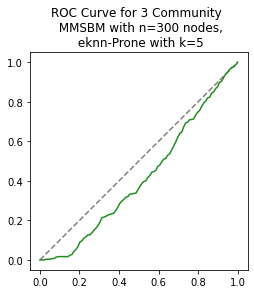

{'area_above': 4.621049800112806e-05,
 'area_below': 0.08563203507372473,
 'total_area': 0.08567824557172586}

In [75]:
p_hat_list = p_vals_prone
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for 3 Community \n MMSBM with n={n} nodes,\n knn-Prone with k={k}")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig(f"figs/MMSBM_knnProneResample_k{k}_M{M}_SYMM.png")

plt.show()

compute_roc_and_areas(p_vals_prone, significance_level=0.05)

## Change n, run each method and record score to then plot

make more Atrue draws

In [76]:
# Generate more samples from the same model with the same B matrix and pi vectors
random.seed(100)

n_list = [50,100,200,300,500,750,1000, 1500, 2000]

M=max(n_list)
A_true_draws = []

for m in range(M):
    # use the B matrix from before, B, and the pi vectors, pi_list
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            z_ij = np.random.multinomial(1, pi_list[i].flatten())#.tolist())
            z_ji = np.random.multinomial(1, pi_list[j].flatten())#.tolist())

            P[i,j] = z_ij @ B @ z_ji.T

    A = (np.random.uniform(0, 1, n**2).reshape(n, n) < P)

    A = A.astype(float)

    # make symmetric by setting the lower triangle equal to the upper triangle
    A = np.triu(A) + np.triu(A).T - np.diag(A.diagonal())

    A_true_draws.append(A)

    #3 mins runtime for M=300

knn with all k values

In [77]:
random.seed(100)
np.random.seed(100)

k5list = []
k25list = []
k90list = []

for n in n_list:
    n = n
    
    # knn
    for k in [5,25,90]:
        k = k
        # for each of the true draws from the model, create a bootstrap and perform a test with Q permutations

        p_vals_k = []
        A_boots_list_k = []

        for m in A_true_draws[0:n]:
            p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=k)
            p_vals_k.append(p_val)
            A_boots_list_k.append(A_boots)

        p_hat_list = p_vals_k

        output = compute_roc_and_areas(p_vals_k, significance_level=0.05)
        # print(list(output.items())[2])

        if k == 5:
            k5list.append(list(output.items())[2][1])
        elif k == 25:
            k25list.append(list(output.items())[2][1])
        elif k == 90:
            k90list.append(list(output.items())[2][1])
        else:
            print("error")

YYT

In [78]:
random.seed(100)
np.random.seed(100)

YYTlist = []

for n in n_list:
    n = n

    p_vals_YYT = []
    A_boots_list_YYT = []


    for m in A_true_draws[0:n]:
        p_val, A_boots = create_single_YYT_bootstrap_cropPto0_1range(m,d=d,Q=1000)
        p_vals_YYT.append(p_val)
        A_boots_list_YYT.append(A_boots)

    p_hat_list = p_vals_YYT

    output = compute_roc_and_areas(p_vals_YYT, significance_level=0.05)
    # print(list(output.items())[2])

    YYTlist.append(list(output.items())[2][1])

/home/uj21900/Documents/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:193: UserWarning: P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.
  warnings.warn("P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.")


#### knn prone

In [79]:
random.seed(100)
np.random.seed(100)

k5pronelist = []
k25pronelist = []
k90pronelist = []

for n in n_list:
    n = n
    
    # knn
    for k in [5,25,90]:
        k = k
        # for each of the true draws from the model, create a bootstrap and perform a test with Q permutations

        p_vals_k = []
        A_boots_list_k = []

        for m in A_true_draws[0:n]:
            p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=k)
            p_vals_k.append(p_val)
            A_boots_list_k.append(A_boots)

        p_hat_list = p_vals_k

        output = compute_roc_and_areas(p_vals_k, significance_level=0.05)
        # print(list(output.items())[2])

        if k == 5:
            k5pronelist.append(list(output.items())[2][1])
        elif k == 25:
            k25pronelist.append(list(output.items())[2][1])
        elif k == 90:
            k90pronelist.append(list(output.items())[2][1])
        else:
            print("error")

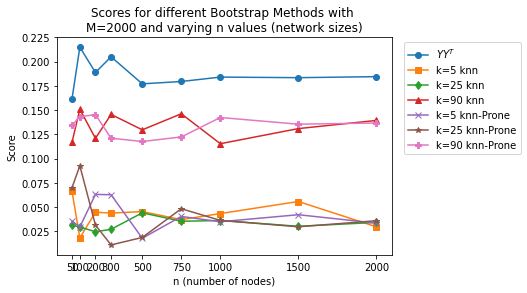

In [83]:
# Plot the lists
plt.plot(n_list, YYTlist, label="$YY^T$", marker='o')
plt.plot(n_list, k5list, label="k=5 knn", marker='s')
plt.plot(n_list, k25list, label="k=25 knn", marker='d')
plt.plot(n_list, k90list, label="k=90 knn", marker='^')
plt.plot(n_list, k5pronelist, label="k=5 knn-Prone", marker='x')
plt.plot(n_list, k25pronelist, label="k=25 knn-Prone", marker='*')
plt.plot(n_list, k90pronelist, label="k=90 knn-Prone", marker='P')

# Add labels and title
plt.xlabel("n (number of nodes)")
plt.ylabel("Score")
plt.title(f"Scores for different Bootstrap Methods with \nM={M} and varying n values (network sizes)")

# add xticks for the n_list
plt.xticks(n_list)

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1))

plt.savefig(f"figs/MMSBM_scores_varying_n_M{M}_SYMM.png")

plt.show()